<a href="https://colab.research.google.com/github/zscialom/RL_Research/blob/heatmaps/RESEARCH_PAPER_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal Execution Problem: Liquidation

### Import the necessary libraries

In [ ]:
# import packages

import numpy as np
import matplotlib
import pandas as pd
from scipy.stats import norm
import copy
from tqdm import tqdm 
import time

import scipy.io as sio  # for loading matlab data
import csv
from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
from statsmodels.tsa import stattools
from statsmodels.graphics import gofplots
from scipy import stats
from statsmodels.tsa import arima_model
from statsmodels.regression import linear_model
import statsmodels.api as sm

In [ ]:
%matplotlib inline

### Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ticker = 'MSFT'

In [ ]:
data = sio.loadmat('/content/drive/Shared drives/ProjectML/Project/Nov-2014/'+ticker+'_20141103.mat')

In [ ]:
data['LOB']['EventTime']

array([[array([[34200100],
               [34200200],
               [34200300],
               ...,
               [57599800],
               [57599900],
               [57600000]], dtype=int32)]], dtype=object)

In [ ]:
LOB=data['LOB']

# There is a pdf "Data_Description" that also details the field
# The file contains a structure called LOB where each field has entries corresponding to one second of the trading day

# time stamp is milliseconds from midnight at the start of the second
time_adj = 1e-3                   # this number is for time adjustment, the time unite in raw data is millisecond
price_adj = 1e-4                  # this number is for price correction, the price quoted in raw data is in price*1e4 form
t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*time_adj  # time in seconds (hence 1e-3), measured from NASDAQ opening at 9:30am (hence 3600000*9.5)
bid = np.array(LOB['BuyPrice'][0][0]*price_adj)                      # bid price in the given 0.1 second interval (1e-4 needed because of the way the data has been obtained)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)                   # bid volumes in the given 0.1 second interval                  
ask = np.array(LOB['SellPrice'][0][0]*price_adj)                     # ask price in the given 0.1 second interval
askvol = np.array(LOB['SellVolume'][0][0]*1.0)                  # ask volumes in the given 0.1 second interval
nMO = np.array(LOB['NumberMO'][0][0]*1.0)                       # total number of MOs submitted in the given 0.1 second interval
vMO = np.array(LOB['VolumeMO'][0][0]*1.0)                       # total volume of MOs submitted in the given 0.1 second interval
MO=np.array(LOB['MO'][0][0]*1.0)                                # information about market orders: number of MOs in the given 0.1 second interval
dt = t[1]-t[0]                                                  # dt = 0.1 second
print(dt)
print(t[0])
print(t[-1])

0.1
0.1
23400.0


## Order Flow

<Figure size 432x288 with 0 Axes>

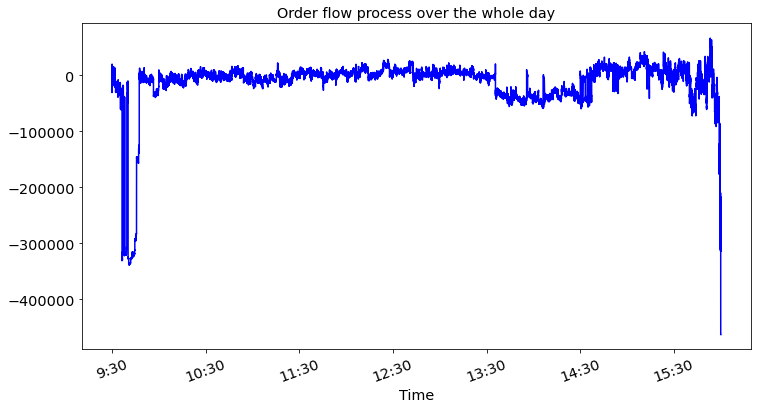

In [ ]:
# Order Flow
# definition: sum of the 10 best bid volumes - sum of the 10 best ask volumes

nVol_OF = 10   # number of best volumes considered (10 in our case)
order_flow = np.sum(bidvol[:,:nVol_OF],axis=1)-np.sum(askvol[:,:nVol_OF],axis=1) 
#dOF = order_flow[1:]-order_flow[:-1]                                   # delta order flow (increments)

plt.figure()
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(order_flow,'b')
plt.title('Order flow process over the whole day')
plt.xlabel('Time')
plt.xticks([0, 36000, 72000, 108000, 144000, 180000,216000], ['9:30', '10:30', '11:30','12:30','13:30', '14:30', '15:30'], rotation=20)
plt.savefig('/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures/'+ticker+'/Order_flow_process.png')

### Prices: Midprice, Microprice and LO Imbalance


In [ ]:
# Midprice
midprice = 0.5*(bid[:,0]+ask[:,0])
#print(midprice)

# Microprice
microprice = (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])

# Microprice Increments/Delta
#dmicro = microprice[1:]-microprice[:-1]

# LO imbalance for each time stamp
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T


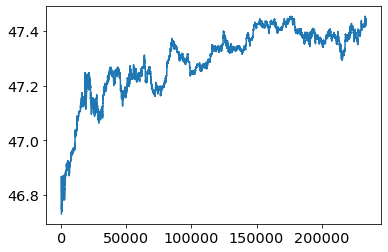

In [ ]:
plt.plot(microprice)

### Discretization microprice values: Finite Markov Decision Processes

In [ ]:
len(microprice[211*10*60-1:len(t)-(178*60+59)*10]) # 101

11

## Setting Up the Market Impact Problem

We assume $N$ number of shares to liquidate, $M$ possible microprices and $T$ time steps. All combinations of state and time can then be represented as a four-dimensional grid of size $N_1\times M\times T$. A time-dependent action-value function $ Q_t(s_t, a_t)$ with $N_2$ possible actions can then be stored as a rank-four tensor of dimension $N_1\times M\times T \times N_2$. 

## Setting some global parameters

### Trading Window: 13:01 to 15:30



-> Details about the choice of the trading window can be found on the report.

In [ ]:
# Work on the trading window

#the timestamp is 0.1 second so we need to multiply the time by 10 to get everysecond
secondFreq = 10 # variable needed to work with seconds
oneMinute = 60 

# START TRADING: 13h00
# between 9:30 and 13:00: 3.5 hours so, 210 minutes
# work with 13:01 for convenience
tradStart = 211
initTime = (tradStart*secondFreq*oneMinute)-1       # time for 13:01 am

# STOP TRADING: 15:30 
# 16:00 - 30 minutes
#thirtyMin = 30*secondFreq*60                        # 30 minutes:
#thirtyMin = (178*60+55)*secondFreq                 # 16:00 - 2 hours 58 minutes 55 seconds 5steps
thirtyMin = (177*60+20)*secondFreq                 # 16:00 - 2 hours 57 minutes 20 seconds 100steps
#thirtyMin = (178*60+50)*secondFreq                 # 16:00 - 2 hours 58 minutes 50 seconds 10steps
#thirtyMin = (178*60+10)*secondFreq                 # 16:00 - 2 hours 58 minutes 10 seconds 50steps

# Length of estimation window - 1 hour
N = oneMinute*secondFreq                                

totalTime = len(t)           
tradingTime = t[initTime:totalTime-thirtyMin]       # trading window studied: 1:01pm to 3:30pm - 
tradingTime = tradingTime[::secondFreq]             # take every second (for trading)
tradingTime = np.array(list(map(int, tradingTime)),dtype='int')           # only deal with integers

print(tradingTime)
print(len(tradingTime))
endTrading = int(tradingTime[-1])
print(endTrading)

T0 = 0                                   # initial time for the initial state: time is discretized also, the value 0 is then treated as the initial trading time and so on

[12660 12661 12662 12663 12664 12665 12666 12667 12668 12669 12670 12671
 12672 12673 12674 12675 12676 12677 12678 12679 12680 12681 12682 12683
 12684 12685 12686 12687 12688 12689 12690 12691 12692 12693 12694 12695
 12696 12697 12698 12699 12700 12701 12702 12703 12704 12705 12706 12707
 12708 12709 12710 12711 12712 12713 12714 12715 12716 12717 12718 12719
 12720 12721 12722 12723 12724 12725 12726 12727 12728 12729 12730 12731
 12732 12733 12734 12735 12736 12737 12738 12739 12740 12741 12742 12743
 12744 12745 12746 12747 12748 12749 12750 12751 12752 12753 12754 12755
 12756 12757 12758 12759 12760]
101
12760


In [ ]:
# Discretization in order to have a finite MDP

#pricesDiscr = sorted(set(microprice[0:100]))                      # find number of only unique values to help choose the number of discretized values + sort
#pricesDiscr = np.array(pricesDiscr)                        # converting list to array

# these are arbitrary values set to establish the possible discretized values for the microprice
#minVal = 0.25                                              # minimum value for discretization                      
#maxVal = 0.50                                              # maximum value for discretization
stepDiscr = 5e-4     #0.009                                   # space between two values


minVal= np.min(microprice[tradingTime[0:(len(tradingTime)-1)]*secondFreq])  # 1e-3
maxVal= np.max(microprice[tradingTime[0:(len(tradingTime)-1)]*secondFreq]) + 0.1 #8e-3

#minVal=np.min(microprice[tradingTime[0:10]*secondFreq])  - 0.001
#maxVal=np.max(microprice[tradingTime[0:10]*secondFreq])+ 0.001

micropriceDiscr=np.arange(minVal, maxVal, stepDiscr)

#tab1 = np.arange(min(pricesDiscr)- minVal, max(pricesDiscr), stepDiscr)     # adding certain values in case the execution price is lower than the min of the microprice
#tab2 = np.arange(max(pricesDiscr), max(pricesDiscr)+ maxVal, stepDiscr)     # adding certain values in case the execution price is greater than the max of the microprice
#micropriceDiscr = np.concatenate((tab1, tab2), axis=0)    

#pricesDiscr = sorted(set(microprice))                      # find number of only unique values to help choose the number of discretized values + sort
#pricesDiscr = np.array(pricesDiscr)  
                  # final array with microprice values discretized and considered
print(min(micropriceDiscr), max(micropriceDiscr))
#print(micropriceDiscr)
print(len(micropriceDiscr))

47.33707108257294 47.46057108257353
248


#### Exploration on the trading window without any price impact

MO volumes
[  700.  4352. 11078.  6619.  7370. 11664.  2400.  3500.  4200.  2800.
  1800.  4200.  2100.  2600.  1360.  5000.  1100.  4150.  1500.  4000.]
[ 6180.  6038.  6105.  5224.  3862.  6193.  7000.  1800.  3820.  1820.
  3769.  1927.  4515. 46373.  2580.  3654.  1300.  2300.  1841.  6217.]


Text(0.5, 1.0, 'MO volumes from the beginning of the trading window')

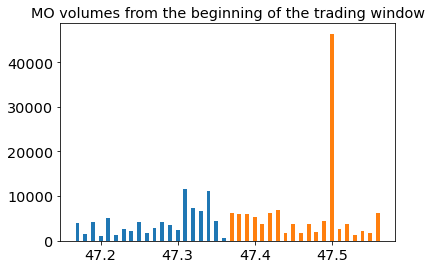

In [ ]:
# Volumes: first second of the trading window
print('MO volumes')
print(bidvol[initTime+1,:])
print(askvol[initTime+1,:])
plt.bar(bid[initTime+1,:],bidvol[initTime+1,:],width=0.005)
plt.bar(ask[initTime+1,:],askvol[initTime+1,:],width=0.005)
plt.show
plt.title("MO volumes from the beginning of the trading window")

Text(0.5, 1.0, 'Evolution of the order flow on the trading window')

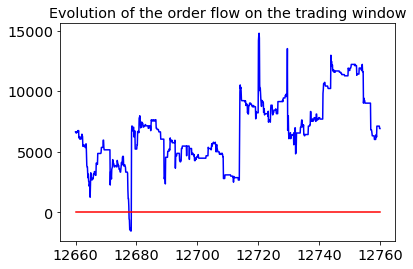

In [ ]:
# 0rder flow on the trading window
mean_OF_TW = np.mean(order_flow[initTime:totalTime-thirtyMin])

plt.figure(1)
plt.plot(t[initTime:totalTime-thirtyMin],order_flow[initTime:totalTime-thirtyMin],'b')
plt.plot(t[initTime:totalTime-thirtyMin:10],np.zeros(len(tradingTime)),'r')
plt.title('Evolution of the order flow on the trading window')

<Figure size 432x288 with 0 Axes>

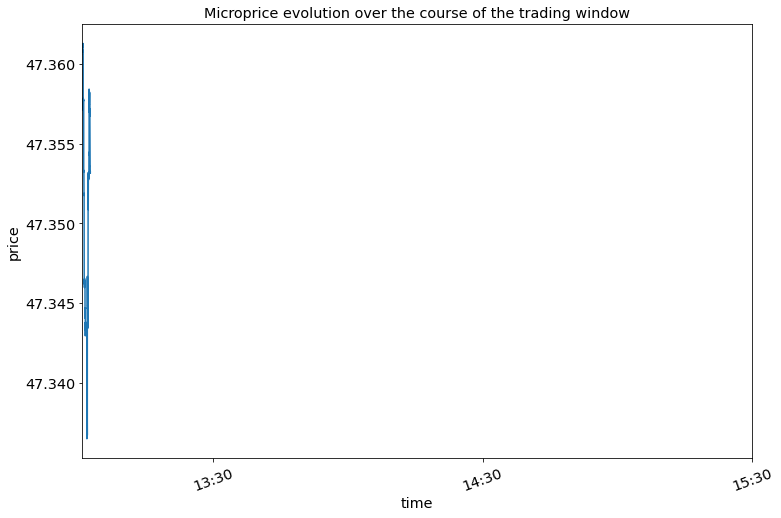

<Figure size 432x288 with 0 Axes>

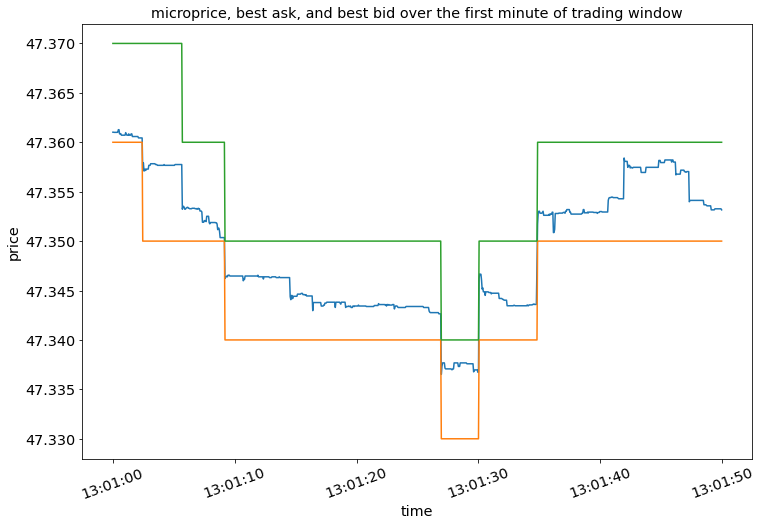

In [ ]:
# Evolution of the microprice on the trading window

plt.figure(1)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(t[initTime:totalTime-thirtyMin],microprice[initTime:totalTime-thirtyMin])
plt.title('Microprice evolution over the course of the trading window')
plt.ylabel('price')
plt.xlabel('time')
plt.xticks([14400, 18000,21600], ['13:30', '14:30', '15:30'], rotation=20)
plt.savefig('/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures/'+ticker+'/Micro_price_evolution_tradingwindow.png')
plt.show()

plt.figure(2)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(t[initTime:initTime+1000],microprice[initTime:initTime+1000])
plt.plot(t[initTime:initTime+1000],bid[initTime:initTime+1000,0])
plt.plot(t[initTime:initTime+1000],ask[initTime:initTime+1000,0])
plt.title('microprice, best ask, and best bid over the first minute of trading window')
plt.ylabel('price')
plt.xlabel('time')
plt.xticks([12660, 12680, 12700, 12720, 12740, 12760], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.xticks([0, 1, 2, 3, 4, 5], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
plt.savefig('/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures/'+ticker+'/microprice_bestBidAsk_firstminute.png')
plt.show()

### Statistic test for AR 1 model and OLS model

In [ ]:
t_ARtest_est_init = 211*60*10-1
t_ARtest_est_31min = 30*60*10
order_flow_sec_test = order_flow[t_ARtest_est_init-N:t_ARtest_est_init:10]
OF_AR1 = sm.tsa.AutoReg(order_flow_sec_test,1)
OF_AR1 = OF_AR1.fit()

OF_AR1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:                     AutoReg(1)   Log Likelihood                -514.268
Method:               Conditional MLE   S.D. of innovations           1476.565
Date:                Thu, 09 Mar 2023   AIC                           1034.537
Time:                        04:16:12   BIC                           1040.769
Sample:                             1   HQIC                          1036.970
                                   60                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3372.4434    711.354      4.741      0.000    1978.214    4766.672
y.L1           0.4641      0.111      4.191      0.000       0.247       0.681
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1547           +0.0000j            2.1547            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
t_OLStest_est_init = 211*60*10-1
t_OLStest_est_31min = 30*60*10
order_flow_OLStest_list = order_flow[t_OLStest_est_init-N:t_OLStest_est_init:10]
microprice_OLStest_list = microprice[t_OLStest_est_init-N:t_OLStest_est_init:10]
OLS_model = sm.OLS(np.diff(microprice_OLStest_list),np.diff(order_flow_OLStest_list))
OLS_model = OLS_model.fit()

OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.690
Model:                            OLS   Adj. R-squared (uncentered):              0.685
Method:                 Least Squares   F-statistic:                              129.0
Date:                Thu, 09 Mar 2023   Prob (F-statistic):                    2.24e-16
Time:                        04:16:14   Log-Likelihood:                          281.89
No. Observations:                  59   AIC:                                     -561.8
Df Residuals:                      58   BIC:                                     -559.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.739e-06   1.53e-07     11.359      0.000    1.43e-06    2.05e-06
==============================================================================
Omnibus:                       11.937   Durbin-Watson:                   2.610
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               29.449
Skew:                           0.386   Prob(JB):                     4.03e-07
Kurtosis:                       6.374   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

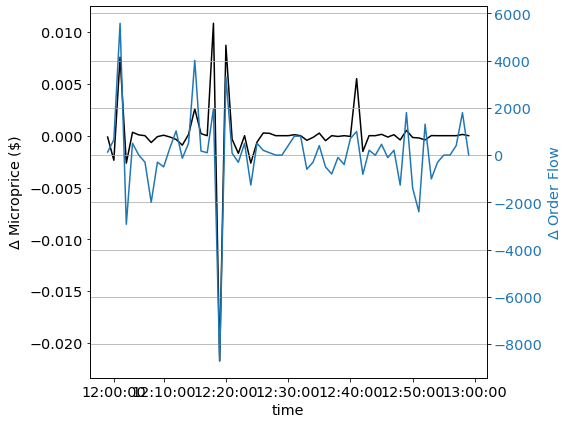

In [ ]:

#plt.plot(Xs_test, color='black')
#plt.plot(Xs_test_0_0_1, color='blue')
fig, ax1 = plt.subplots(figsize=(8,6))
color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('$\Delta$'+ ' Microprice (\$)', color=color)
ax1.plot(t[t_OLStest_est_init-N:t_OLStest_est_init:10][:-1],np.diff(microprice_OLStest_list), color=color)

#ax1.plot(t[initTime:initTime+49], np.diff(microprice[tradingTime[0:50]*secondFreq]), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('$\Delta$' + ' Order Flow', color=color)


linestyle=['-', '--','-.',':']
#ax2.plot(t[initTime:initTime+50],order_flow[initTime:initTime+50], color=color, linestyle=linestyle[0], label='Order Flow')
ax2.plot(t[t_OLStest_est_init-N:t_OLStest_est_init:10][:-1],np.diff(order_flow_OLStest_list), color=color)
#plt.plot(results[0.01]['inventory'], color='green')
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks([12601, 12609, 12619, 12629, 12639, 12649, 12659], ['12:00:00', '12:10:00', '12:20:00','12:30:00','12:40:00','12:50:00', '13:00:00'], rotation=20)

#ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
#plt.legend()
plt.grid()
file_path= '/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures/'+ticker+'/'
fig.savefig(file_path+'Delta_OF_dpi1200.eps', format='eps', dpi=1200)
fig.savefig(file_path+'Delta_OF_dpi600.eps', format='eps', dpi=600)
fig.savefig(file_path+'Delta_OF_dpi300.eps', format='eps', dpi=300)



### Parameters for Reinforcement Learning Exploitation

In [ ]:
BLOCK_SIZE = 40                     # number of shares in a bloc
NUM_BLOCKS = 100                    # initial number of blocks
NUM_S      = len(micropriceDiscr)   # number of discrete values of S
NUM_TIME_STEPS = len(tradingTime)   # total number of seconds
dt         = 1                      # time step: check every two second
scale      = 10**-6                 # scale for risk aversion param
#lmbda      = 0.5                # risk aversion parameter: to be tested with different values then (0, 0.01, 1)
p_star1    = 0.05                   # p-values authorized for Dickey-Fuller test
p_star2    = 0.05                   # p-values authorized for the linear regression
TCost      = 0.0030                 # NASDAQ TCost

In [ ]:
print(NUM_TIME_STEPS, NUM_S )

101 1109


In [ ]:
EPSILON = 0.5       # Probability for exploration
ALPHA = 0.5         # Step size
GAMMA = 1           # Discount factor for Q-Learning and Sarsa

In [ ]:
# Initial microprice necessary to set the MDP problem (state variable)
S0 = (bid[initTime,0]*askvol[initTime,0]+ask[initTime,0]*bidvol[initTime,0])/(bidvol[initTime,0]+askvol[initTime,0])  # initial microprice
diff_S0 = np.absolute(micropriceDiscr-S0)                                                                   
S0_index = diff_S0.argmin() # closest index in the discretized microprice values
print(S0)
print(S0_index)

47.36101744186046
48


We define the list of possible actions; which is selling bloc of 40 shares.

5 possible actions: [0, 1, 2, 3, 4].

In [ ]:
ACTIONS = list(range(0,5))
print(ACTIONS)

[0, 1, 2, 3, 4]


We define the state vector for the initial state: the maximum number of stocks, the initial price $S_0$, and time $t = 0$

In [ ]:
START = [NUM_BLOCKS-1, S0_index, 0]

In [ ]:
#TEST SLIPPAGE
print(initTime)
print(bid[initTime,:])
print()
print(ask[initTime,:])
print(bidvol[initTime,0])
print(bidvol[initTime,:nVol_OF]) 


126599
[555.02 555.01 555.   554.99 554.98 554.96 554.95 554.94 554.9  554.89
 554.85 554.81 554.76 554.75 554.74 554.71 554.7  554.66 554.65 554.58]

[555.25 555.27 555.28 555.29 555.35 555.36 555.4  555.45 555.48 555.53
 555.55 555.58 555.59 555.6  555.62 555.65 555.66 555.68 555.69 555.75]
6.0
[  6.   6.   6. 100. 200.  12. 200.  15. 100.  63.]


In [ ]:
def compute_slippage(time_step, actionVol, bid_vol, bid_price, TCost, nVol):
  # actionVol is the volume of the actions taken (BLOCK_SIZE * NUMBER_BLOCS)
  # bid_vol is where there all the volumes for bid at each time step
  # bid_price is where there all the quotes for bid at each time step
  # nVol, the number of level we can go through while walking through the book
  bid_vol_clone = np.array(bid_vol)
  #print(actionVol)
  level = 0                                                                     # level zero is the best bid
  interPrice = []                                                               # list where is stocked volume*price at each level 
  if actionVol <= bid_vol_clone[time_step,level]:                               # easy case: our volume is lower than the best bid volume
    slippage = actionVol*bid_price[time_step,level]                             
    bid_vol_clone[time_step,level] = bid_vol_clone[time_step,level] - actionVol             # update the bid volume on that level
  else: 
    while actionVol >0 and level <= nVol:
      #print("Current Level: ",level)
      #print("Number of shares remaining: ",actionVol)
      interPrice.append(min(actionVol,bid_vol_clone[time_step,level])*(bid_price[time_step,level]-TCost)) # price at the current level * volume
      future_bid_vol_update = actionVol                                                     # intermediate variable to update well the bid volume later
      actionVol = actionVol - bid_vol_clone[time_step,level]                                # upadte on our actions
      bid_vol_clone[time_step,level] = bid_vol_clone[time_step,level] - min(future_bid_vol_update,bid_vol_clone[time_step,level])
      #print("Current level volume: ", bid_vol[time_step,level])
      level += 1                                                                # we go to the next best bid price
    slippage = np.sum(interPrice)
  return slippage


Two tests realized to make sure the slippage function works. \
First test, the volume does not walk the LOB: everything is consumed at the first level (best bid volume).\
Second test, not all shares are executed at the same price, it walks the book.

In [ ]:
#test1 = compute_slippage(initTime, 500, bidvol, bid, nVol_OF)
#print(test1)
test2 = compute_slippage(initTime, 800, bidvol, bid, TCost, nVol_OF)
print(test2)

443950.67


In [ ]:
price_impact_list = []
intercept_list = []
phi_list = []

for i in range(len(tradingTime)):
  OF_hat = order_flow[tradingTime[i]*secondFreq-N:tradingTime[i]*secondFreq]
  microprice_hat = microprice[tradingTime[i]*secondFreq-N:tradingTime[i]*secondFreq] 
  phi, sigma = linear_model.yule_walker(OF_hat,order=1)     # Yules-Walker equation
  if abs(phi[0])>1:
      phi[0] = phi[0]/abs(phi[0]) # -1 or 1 according to phi sign
  phi_list.append(phi[0])

  price_impact, intercept, r_value, p_value2, std_err = stats.linregress(np.diff(OF_hat),np.diff(microprice_hat))  # regression between (St) and (OFt)
  price_impact_list.append(price_impact)
  intercept_list.append(intercept)


In [ ]:
print(phi_list)
print(price_impact_list)
print(tradingTime*secondFreq)

[0.961602435957551, 0.9663439024385576, 0.9653790195259853, 0.9600656601378373, 0.9635746378576205, 0.9621679598300534, 0.9536420837567032, 0.9641813130158973, 0.9684488101472772, 0.9741226845443068, 0.9769543444629004, 0.979048947741483, 0.9809251450281368, 0.9820290771867779, 0.9830494645411745, 0.9837100811572047, 0.982396546637717, 0.9822417813538129, 0.9806454746425732, 0.9822618530935759, 0.9830576205751609, 0.9825698566785376, 0.9820311301143425, 0.9814352623684564, 0.9815827250594443, 0.9811875918451957, 0.9787554450530417, 0.9787298546960959, 0.9778554877047653, 0.9769709653406052, 0.9754215471087115, 0.980061556969704, 0.9796122637999896, 0.9794619661436702, 0.9790610338131973, 0.9788809998177538, 0.9791482114697353, 0.9787392728507778, 0.9753008083266799, 0.9749221396035943, 0.9756076547775054, 0.9756248439369407, 0.9760937417772895, 0.9756810958833743, 0.9754380008593082, 0.9749559662870396, 0.9729903184449887, 0.9735748164376014, 0.9722407432406833, 0.9715647565517346, 0.9

Step function that describes how the next state is obtained from the current state and the action taken. The function returns the next state and the reward obtained.

In [ ]:
def step(state, action):
    reward = 0
    cash = 0
    X, S_index, time_t = state

    if action >= X:
      action = X  
    elif action < X and time_t==len(tradingTime)-2:
      action = X
    
    # Calculate the number of stocks remaining: X_next
    X_next = X - action
    #print("X_next %d action: %d" % (X, action))
    # Order flow window
    order_flow = np.sum(bidvol[:,:nVol_OF],axis=1)-np.sum(askvol[:,:nVol_OF],axis=1)  # I think that line is needed: to make sure it incorporates the changes we made through slippage calc
    OF_hat = order_flow[tradingTime[time_t]*secondFreq-N:tradingTime[time_t]*secondFreq]   # Order Flow on the estimation window

    #start = time.process_time()
    # Slippage computation
    slippage = compute_slippage(time_t, action*BLOCK_SIZE, bidvol, bid, TCost, nVol_OF) 
    #print(time.process_time() - start)
    cash = slippage  # will be the first part of the reward
    #order_flow = np.sum(bidvol[:,:nVol_OF],axis=1)-np.sum(askvol[:,:nVol_OF],axis=1)  

    alpha = price_impact_list[time_t]*(1-phi_list[time_t]**secondFreq)*(OF_hat[-1] - action*BLOCK_SIZE) + intercept_list[time_t]   # expected change predicted with the price impact (the variable price impact contains lambda and phi1)
    S_execution = micropriceDiscr[S_index] + alpha # second part of the reward function  # estimation of St+1: predicted price = current price - expected change predicted with the price impact
    #S_execution = microprice[tradingTime[time_t]*secondFreq] + alpha # second part of the reward function  # estimation of St+1: predicted price = current price - expected change predicted with the price impact
    
    S_next = S_execution 
    # Quantise S_next to an allowed value
    #S_next = np.around(S_next, decimals=4)
    #0.009
    if S_next > np.max(micropriceDiscr) or S_next < np.min(micropriceDiscr):
      print("!!! --- error S_next is off the grid --- ")

    difference_array = np.absolute(micropriceDiscr-S_next)
    S_index = difference_array.argmin()
    #print(S_next, np.min(micropriceDiscr), np.max(micropriceDiscr), S_index, S_execution, alpha, tradingTime[time_t]*secondFreq, time_t)
    #print("S_next = %4.2f, S_index=   %4.2f" %(S_next, micropriceDiscr[S_index]))

    # Next State  
    next_state = [X_next, S_index, time_t+dt]
    
    # Calculate the reward earned from the sale    
    reward += cash - scale*lmbda*BLOCK_SIZE**2*(X_next**2)*(S_execution**2)
    
    return next_state, reward, cash

In [ ]:
np.min( microprice[tradingTime[0:10]*secondFreq])+0.004, np.max( microprice[tradingTime[0:10]*secondFreq]+0.004)

(554.882679245283, 555.12922875817)

In [ ]:
np.min(micropriceDiscr), np.max(micropriceDiscr)

(554.7632063492064, 555.3172063491933)

In [ ]:
# Check some state, action pairs and the associated reward
print(step(START, 0))
# print(step([20,100,4], 0))

([99, 536, 1], -2415433.4010602995, 0.0)


### Set up the agent's action policy

Given $S_t$ and $Q_t\left( s_t, a_t\right)$, this function chooses an action based on the epsilon-greedy algorithm

In [ ]:
# Choose an action based on epsilon greedy algorithm
def choose_action(state, q_value, eps=EPSILON):
    # With probability `eps', simply choose a random action - 'Exploration'
    if np.random.binomial(1, eps) == 1:
        action = np.random.choice(ACTIONS)
    # Otherwise, choose from the actions with the highest
    # q-value for the given state - 'Exploitation'
    else:
        values_ = q_value[state[0], state[1], :]
        action = np.random.choice(
            [action_ for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    # You cannot sell more stocks than you have
    if action > state[0]:
        action = state[0]
    return action

For example, when `q_value` is all zeroes, the action taken is always random:

In [ ]:
q_value = np.zeros((NUM_BLOCKS, NUM_S, len(ACTIONS)))
choose_action(START, q_value, EPSILON)

0

### Set up the learning algorithms

#### Sarsa and Expected Sarsa

This function simulates an episode with Sarsa. It takes the state-action value array `q_value` as an argument, initialises the state to `START`, defined above, and updates `q_value` according to the Sarsa algorithm, until the $T$ time steps have passed, or the stocks have all been sold. The cumulative reward earned is returned.

In [ ]:
def sarsa(q_value, expected=False, step_size=ALPHA, eps=EPSILON):
    state = START
    action = choose_action(state, q_value,eps)
    rewards = 0.0
    total_cash = 0.0          # accumulate cash earnings during the whole trading period
    #actions = 0

    while (state[2] < (NUM_TIME_STEPS-1)*dt) and (state[0] > 0):
        #start = time.process_time()
        next_state, reward, cash = step(state, action)
        #print(time.process_time() - start)
        next_action = choose_action(next_state, q_value, eps)
        #print("")
        rewards += reward
        total_cash += cash    # accumulate cash earnings during the whole trading period
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # Calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], next_state[2], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - eps) / len(best_actions) 
                               + eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], next_state[2], action_]
                else:
                    target += eps / len(ACTIONS) * q_value[next_state[0], next_state[1], next_state[2], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1],  action])
        state = next_state
        action = next_action
        #print(total_cash)

    #print("state[0] %d" % state[0])    
    return rewards, total_cash

### Running Sarsa 

This function will plot the average (over `runs` independent trials) rewards earned by SARSA and Q-learning after each iteration (up to `episodes`).

Text(0, 0.5, 'epsilon')

<Figure size 432x288 with 0 Axes>

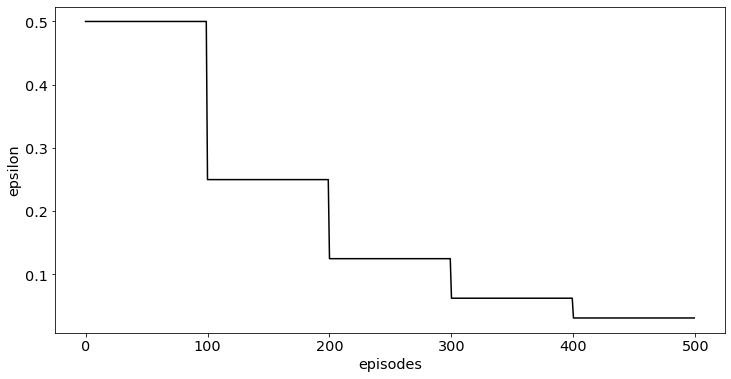

In [ ]:

num_episodes = 500
EPOCH=0.2*num_episodes 
list_eps = []
for i in range(0, num_episodes):
  eps_val = EPSILON*((1-EPSILON)**(i//EPOCH))
  list_eps.append(eps_val)

plt.figure()
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(list_eps,'k')
plt.xlabel("episodes")
plt.ylabel('epsilon')

#plt.savefig('/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures'+ticker+'/epsilon.png')

In [ ]:
def trainSarsa(episodes=1000, runs=100, epoches=10):
    EPOCH=epoches
    EPOCH_=0.2*episodes
    
    # Initialise the rewards arrays
    rewards_sarsa = np.zeros(episodes)
    total_cash_list = np.zeros(episodes)
    q_sarsa_avg = np.zeros((NUM_BLOCKS, NUM_S, len(ACTIONS)))
    #q_sarsa_avg = np.zeros((NUM_BLOCKS, NUM_S, len(ACTIONS)))
    for r in tqdm(range(runs)):
        # Initialise the state-action arrays 
        q_sarsa = np.zeros((NUM_BLOCKS, NUM_S,  len(ACTIONS)))
        #q_sarsa = np.zeros((NUM_BLOCKS, NUM_S, len(ACTIONS)))
        # Update the rewards and action value arrays for each episode
        for i in range(0, episodes):
            if i%10 ==0:
               print("episode %d" %i)
            # The value of epsilon is decremented exponentially
            # after every EPOCH episodes
            eps = EPSILON*((1-EPSILON)**(i//EPOCH_))
            rewards, total_cash = sarsa(q_sarsa,eps=eps)
            q_sarsa_avg += q_sarsa
            rewards_sarsa[i] += rewards
            total_cash_list[i] += total_cash
    # Averaging over independent runs
    rewards_sarsa /= runs
    total_cash_list /= runs
    q_sarsa_avg /= runs
    
    # Draw reward curves
    plt.plot(rewards_sarsa, label='Sarsa',color='black')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.legend()

    return q_sarsa_avg, rewards_sarsa, total_cash_list


In [ ]:
q_sarsa = {}
rewards_sarsa = {}
total_cash_list = {}
lmbda_list = [0,0.0001,0.001,0.01,0.1,0.2,0.5,1]

for lmbda in lmbda_list:
  q_sarsa[lmbda], rewards_sarsa[lmbda], total_cash_list[lmbda] = trainSarsa(500, 3, 100)

  0%|          | 0/3 [00:00<?, ?it/s]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


 33%|███▎      | 1/3 [09:13<18:26, 553.05s/it]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50


In [ ]:
for lmbda in lmbda_list:
  df_rewards_sarsa = pd.DataFrame(rewards_sarsa[lmbda])
  rewards_file_name = "rewards_lmbda_" + str(lmbda) +".csv"
  df_rewards_sarsa.to_csv("/content/drive/Shared drives/ProjectML/Project/Results"+ticker+"/Rewards/" + rewards_file_name)
  #!cp rewards_file_name "/content/drive/Shared drives/ProjectML/Project/Results/Rewards"

In [ ]:
# Save Q-Matrix:

#Binary data
for lmbda in lmbda_list:
  np.save('/content/drive/Shared drives/ProjectML/Project/Q-matrices/'+ticker+'/qmatrix_lmbda_' + str(lmbda) + '.npy', q_sarsa[lmbda])

#Human readable data
#np.savetxt('maximums.txt', CXY)

In [ ]:
# Load the Q-matrix
figure_folder_matrix = "/content/drive/Shared drives/ProjectML/Project/Figures"
path = "%s/%s" % (figure_folder_matrix,'qmatrix_01_100sec.npy')
q_matrix_lmbda01 = np.load(path)
path = "%s/%s" % (figure_folder_matrix,'qmatrix_1_100sec.npy')
q_matrix_lmbda1 = np.load(path)
path = "%s/%s" % (figure_folder_matrix,'qmatrix_10_100sec.npy')
q_matrix_lmbda10 = np.load(path)
path = "%s/%s" % (figure_folder_matrix,'qmatrix_100_100sec.npy')
q_matrix_lmbda100 = np.load(path)

q_file_name = 'qmatrix_lmbda_' + str(lmbda) + '.npy'
path = "%s/%s" % (figure_folder_matrix,q_file_name)
q_matrix_test = np.load(path)

In [ ]:
s_0 = S0_index
X_0 = NUM_BLOCKS

s_test = s_0
X_test = X_0
acc_reward_test = 0
acc_cash_test = 0
Xs_test = [X_0]
reward_process_test = [0]
cash_process_test = [0]
a_star_process_test = []

for time_t in range(NUM_TIME_STEPS):
  a_star_test = q_matrix_test[X_test-1,s_test,:].argmax()
  a_star_process_test.append(a_star_test)
  next_state_test, reward_test, cash_test = step([X_test,s_test,time_t],a_star_test)
  X_test = next_state_test[0]
  Xs_test.append(X_test)
  s_test = next_state_test[1]
  acc_reward_test += reward_test
  reward_process_test.append(acc_reward_test)
  acc_cash_test += cash_test
  cash_process_test.append(acc_cash_test)



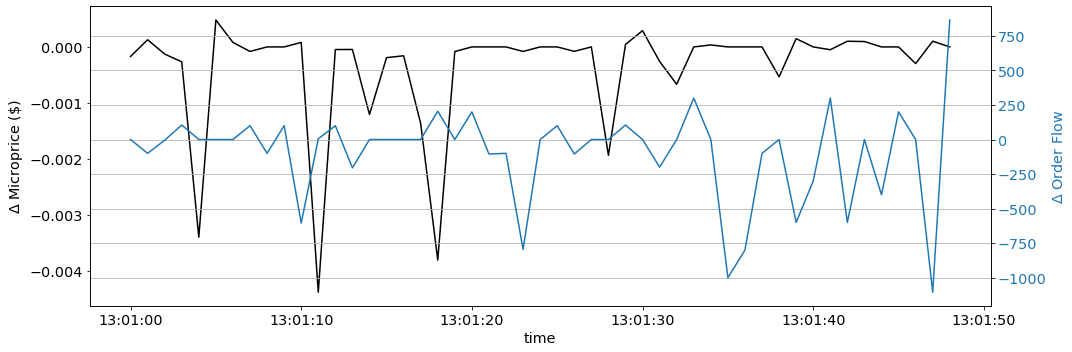

In [ ]:
#plt.plot(Xs_test, color='black')
#plt.plot(Xs_test_0_0_1, color='blue')
fig, ax1 = plt.subplots()
color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('$\Delta$' + ' Microprice (\$)', color=color)
ax1.plot(t[initTime:initTime+49], np.diff(microprice[tradingTime[0:50]*secondFreq]), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('$\Delta$' + ' Order Flow', color=color)


linestyle=['-', '--','-.',':']
ax2.plot(t[initTime:initTime+49],np.diff(order_flow[initTime:initTime+50]), color=color, linestyle=linestyle[0], label='Order Flow')

#plt.plot(results[0.01]['inventory'], color='green')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
#plt.legend()
plt.grid()
fig.savefig('OF_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('OF_dpi600.eps', format='eps', dpi=600)
fig.savefig('OF_dpi300.eps', format='eps', dpi=300)



In [ ]:
results={}

In [ ]:
import pickle

with open('/content/drive/Shared drives/ProjectML/Project/Results/results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
results[lmbda]={}
results[lmbda]['cash']= cash_process_test
results[lmbda]['reward']= reward_process_test
results[lmbda]['inventory']= Xs_test

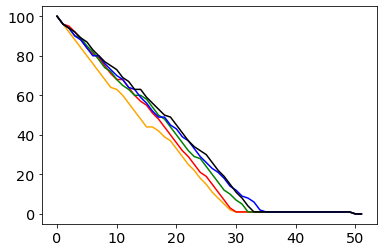

In [ ]:

#plt.plot(results[1]['inventory'])
plt.plot(results[0.5]['inventory'], color='orange')
plt.plot(results[0.1]['inventory'], color='red')
plt.plot(results[0.01]['inventory'], color='green')
plt.plot(results[0.001]['inventory'], color='blue')
plt.plot(results[0.0001]['inventory'], color='black')

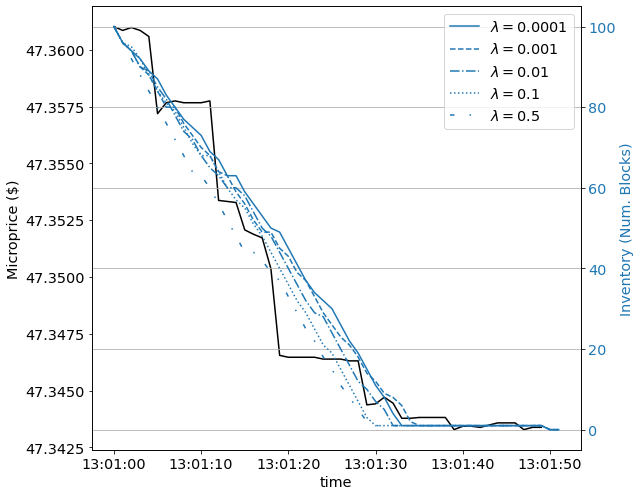

In [ ]:
#plt.plot(Xs_test, color='black')
#plt.plot(Xs_test_0_0_1, color='blue')

fig, ax1 = plt.subplots(figsize=(9, 7))
color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('Microprice ($)', color=color)
ax1.plot(t[initTime:initTime+50], microprice[tradingTime[0:50]*secondFreq], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Inventory (Num. Blocks)', color=color)


linestyle=['-', '--','-.',':',(0, (3, 10, 1, 10))]
ax2.plot(t[initTime:initTime+52],results[0.0001]['inventory'], color=color, linestyle=linestyle[0], label='$\lambda=0.0001$')
ax2.plot(t[initTime:initTime+52],results[0.001]['inventory'], color=color,linestyle=linestyle[1], label='$\lambda=0.001$')

#plt.plot(results[0.01]['inventory'], color='green')
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(t[initTime:initTime+52],results[0.01]['inventory'], color=color, linestyle=linestyle[2], label='$\lambda=0.01$')
ax2.plot(t[initTime:initTime+52],results[0.1]['inventory'], color=color, linestyle=linestyle[3],  label='$\lambda=0.1$')
ax2.plot(t[initTime:initTime+52],results[0.5]['inventory'], color=color, linestyle=linestyle[4],  label='$\lambda=0.5$')
ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
plt.legend()
plt.grid()
fig.savefig('inventory_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('inventory_dpi600.eps', format='eps', dpi=600)
fig.savefig('inventory_dpi300.eps', format='eps', dpi=300)



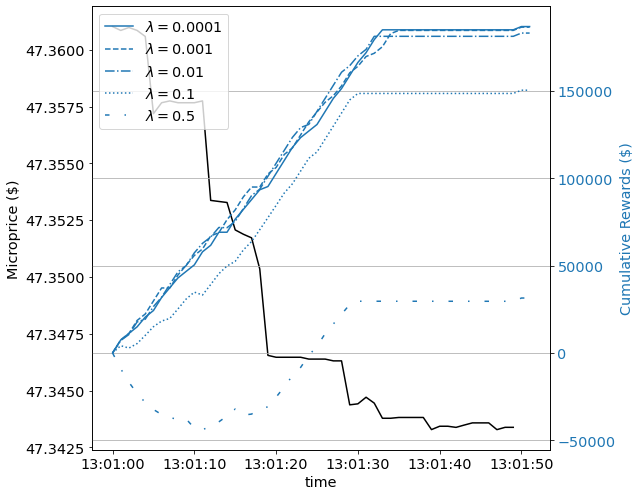

In [ ]:
fig, ax1 = plt.subplots(figsize=(9, 7))
color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('Microprice ($)', color=color)
ax1.plot(t[initTime:initTime+50], microprice[tradingTime[0:50]*secondFreq], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Cumulative Rewards ($)', color=color)


linestyle=['-', '--','-.',':',(0, (3, 10, 1, 10))]
ax2.plot(t[initTime:initTime+52],results[0.0001]['reward'], color=color, linestyle=linestyle[0], label='$\lambda=0.0001$')
ax2.plot(t[initTime:initTime+52],results[0.001]['reward'], color=color,linestyle=linestyle[1], label='$\lambda=0.001$')

#plt.plot(results[0.01]['inventory'], color='green')
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(t[initTime:initTime+52],results[0.01]['reward'], color=color, linestyle=linestyle[2], label='$\lambda=0.01$')
ax2.plot(t[initTime:initTime+52],results[0.1]['reward'], color=color, linestyle=linestyle[3],  label='$\lambda=0.1$')
ax2.plot(t[initTime:initTime+52],results[0.5]['reward'], color=color, linestyle=linestyle[4],  label='$\lambda=0.5$')

ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
plt.legend()
plt.grid()
fig.savefig('reward_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('reward_dpi600.eps', format='eps', dpi=600)
fig.savefig('reward_dpi300.eps', format='eps', dpi=300)

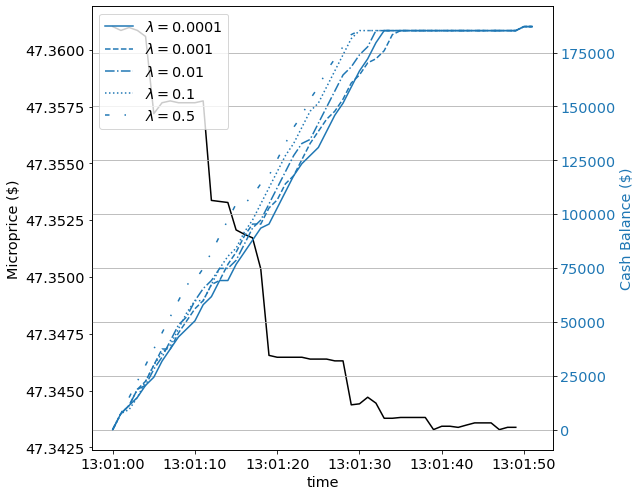

In [ ]:
fig, ax1 = plt.subplots(figsize=(9, 7))

color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('Microprice ($)', color=color)
ax1.plot(t[initTime:initTime+50], microprice[tradingTime[0:50]*secondFreq], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Cash Balance ($)', color=color)


linestyle=['-', '--','-.',':',(0, (3, 10, 1, 10))]
ax2.plot(t[initTime:initTime+52],results[0.0001]['cash'], color=color, linestyle=linestyle[0], label='$\lambda=0.0001$')
ax2.plot(t[initTime:initTime+52],results[0.001]['cash'], color=color,linestyle=linestyle[1], label='$\lambda=0.001$')

#plt.plot(results[0.01]['inventory'], color='green')
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(t[initTime:initTime+52],results[0.01]['cash'], color=color, linestyle=linestyle[2], label='$\lambda=0.01$')
ax2.plot(t[initTime:initTime+52],results[0.1]['cash'], color=color, linestyle=linestyle[3],  label='$\lambda=0.1$')
ax2.plot(t[initTime:initTime+52],results[0.5]['cash'], color=color, linestyle=linestyle[4],  label='$\lambda=0.5$')

ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
plt.legend()
plt.grid()
fig.savefig('cash_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('cash_dpi600.eps', format='eps', dpi=600)
fig.savefig('cash_dpi300.eps', format='eps', dpi=300)

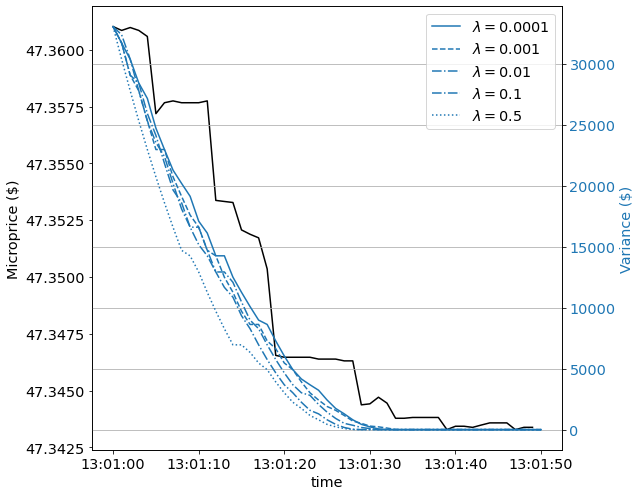

In [ ]:
fig, ax1 = plt.subplots(figsize=(9, 7))
color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('Microprice ($)', color=color)
ax1.plot(t[initTime:initTime+50], microprice[tradingTime[0:50]*secondFreq], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Variance ($)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

linestyle=['-', '--','-.',':',(0, (3, 10, 1, 10))]
#ax2.plot(t[initTime:initTime+52],results[0]['inventory'], color=color, linestyle=linestyle[0], label='$\lambda=0$')
ax2.plot(t[initTime:initTime+51],np.diff((np.array(results[0.0001]['cash'])-np.array(results[0.0001]['reward']))/0.0001), color=color,linestyle=linestyle[0], label='$\lambda=0.0001$')

#plt.plot(results[0.01]['inventory'], color='green')
ax2.plot(t[initTime:initTime+51],np.diff((np.array(results[0.001]['cash'])-np.array(results[0.001]['reward']))/0.001), color=color, linestyle=linestyle[1], label='$\lambda=0.001$')
ax2.plot(t[initTime:initTime+51],np.diff((np.array(results[0.01]['cash'])-np.array(results[0.01]['reward']))/0.01), color=color, linestyle=linestyle[2], label='$\lambda=0.01$')
ax2.plot(t[initTime:initTime+51],np.diff((np.array(results[0.1]['cash'])-np.array(results[0.1]['reward']))/0.1), color=color, linestyle=linestyle[2],  label='$\lambda=0.1$')
ax2.plot(t[initTime:initTime+51],np.diff((np.array(results[0.5]['cash'])-np.array(results[0.5]['reward']))/0.5), color=color, linestyle=linestyle[3],  label='$\lambda=0.5$')

ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
plt.legend()
plt.grid()
fig.savefig('variance_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('variance_dpi600.eps', format='eps', dpi=600)
fig.savefig('variance_dpi300.eps', format='eps', dpi=300)



In [ ]:
costs=NUM_BLOCKS*BLOCK_SIZE*microprice[tradingTime[0]*secondFreq] -[results[0.0001]['cash'][-1], results[0.001]['cash'][-1], results[0.01]['cash'][-1], results[0.1]['cash'][-1], results[0.5]['cash'][-1], results[1]['cash'][-1]]

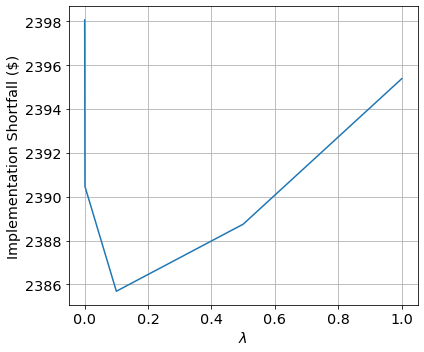

In [ ]:
fig = plt.figure(figsize=(6,5))
#plt.plot(, costs[[0,1,3,4,5]], color='black')
x=[0.0001,0.001,0.1,0.5,1]
y=costs[[0,1,3,4,5]]
poly = np.polyfit(x, y, deg=2)
model1 = np.poly1d(np.polyfit(x, y, 3))
plt.plot(x,y)
#plt.plot(x,model1(x))
plt.ylabel("Implementation Shortfall ($)")
plt.xlabel('$\lambda$')
fig.tight_layout()
plt.grid()
fig.savefig('IS_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('IS_dpi600.eps', format='eps', dpi=600)
fig.savefig('IS_dpi300.eps', format='eps', dpi=300)


In [ ]:
NUM_BLOCKS*BLOCK_SIZE*microprice[tradingTime[0]*secondFreq] -results[0.01]['cash'][-1]

187043.87999999998

In [ ]:
results[0.1]['cash'][-1]

187052.6

In [ ]:
results[0.5]['cash'][-1]

187051.63999999998

In [ ]:
results[1]['cash'][-1]

187057.83999999997

In [ ]:
s_0 = S0_index
X_0 = NUM_BLOCKS

s_lmbda01 = s_0
X_lmbda01 = X_0
acc_reward_lmbda01 = 0
acc_cash_lmbda01 = 0
Xs_lmbda01 = [X_0]
reward_process_lmbda01 = [0]
cash_process_lmbda01 = [0]

s_lmbda1 = s_0
X_lmbda1 = X_0
acc_reward_lmbda1 = 0
acc_cash_lmbda1 = 0
Xs_lmbda1 = [X_0]
reward_process_lmbda1 = [0]
cash_process_lmbda1 = [0]

s_lmbda10 = s_0
X_lmbda10 = X_0
acc_reward_lmbda10 = 0
acc_cash_lmbda10 = 0
Xs_lmbda10 = [X_0]
reward_process_lmbda10 = [0]
cash_process_lmbda10 = [0]

s_lmbda100 = s_0
X_lmbda100 = X_0
acc_reward_lmbda100 = 0
acc_cash_lmbda100 = 0
Xs_lmbda100 = [X_0]
reward_process_lmbda100 = [0]
cash_process_lmbda100 = [0]

for t in range(q_matrix_lmbda1.shape[2]-1):
  a_star_lmbda01 = q_matrix_lmbda01[X_lmbda01-1,s_lmbda01,t,:].argmax()
  next_state_lmbda01, reward_lmbda01, cash_lmbda01 = step([X_lmbda01,s_lmbda01,t],a_star_lmbda01)
  X_lmbda01 = next_state_lmbda01[0]
  Xs_lmbda01.append(X_lmbda01)
  s_lmbda01 = next_state_lmbda01[1]
  acc_reward_lmbda01 += reward_lmbda01
  reward_process_lmbda01.append(acc_reward_lmbda01)
  acc_cash_lmbda01 += cash_lmbda01
  cash_process_lmbda01.append(acc_cash_lmbda01)

  a_star_lmbda1 = q_matrix_lmbda1[X_lmbda1-1,s_lmbda1,t,:].argmax()
  next_state_lmbda1, reward_lmbda1, cash_lmbda1 = step([X_lmbda1,s_lmbda1,t],a_star_lmbda1)
  X_lmbda1 = next_state_lmbda1[0]
  Xs_lmbda1.append(X_lmbda1)
  s_lmbda1 = next_state_lmbda1[1]
  acc_reward_lmbda1 += reward_lmbda1
  reward_process_lmbda1.append(acc_reward_lmbda1)
  acc_cash_lmbda1 += cash_lmbda1
  cash_process_lmbda1.append(acc_cash_lmbda1)

  a_star_lmbda10 = q_matrix_lmbda10[X_lmbda10-1,s_lmbda10,t,:].argmax()
  next_state_lmbda10, reward_lmbda10, cash_lmbda10 = step([X_lmbda10,s_lmbda10,t],a_star_lmbda10)
  X_lmbda10 = next_state_lmbda10[0]
  Xs_lmbda10.append(X_lmbda10)
  s_lmbda10 = next_state_lmbda10[1]
  acc_reward_lmbda10 += reward_lmbda10
  reward_process_lmbda10.append(acc_reward_lmbda10)
  acc_cash_lmbda10 += cash_lmbda10
  cash_process_lmbda10.append(acc_cash_lmbda10)

  a_star_lmbda100 = q_matrix_lmbda100[X_lmbda100-1,s_lmbda100,t,:].argmax()
  next_state_lmbda100, reward_lmbda100, cash_lmbda100 = step([X_lmbda100,s_lmbda100,t],a_star_lmbda100)
  X_lmbda100 = next_state_lmbda100[0]
  Xs_lmbda100.append(X_lmbda100)
  s_lmbda100 = next_state_lmbda100[1]
  acc_reward_lmbda100 += reward_lmbda100
  reward_process_lmbda100.append(acc_reward_lmbda100)
  acc_cash_lmbda100 += cash_lmbda100
  cash_process_lmbda100.append(acc_cash_lmbda100)


plt.figure()
fig, axs = plt.subplots(1, 3,figsize=(16,8))
axs[0].plot(range(q_matrix_lmbda01.shape[2]), Xs_lmbda01)
axs[0].plot(range(q_matrix_lmbda1.shape[2]), Xs_lmbda1)
axs[0].plot(range(q_matrix_lmbda10.shape[2]), Xs_lmbda10)
axs[0].plot(range(q_matrix_lmbda100.shape[2]), Xs_lmbda100)
axs[0].set_ylabel("inventory")
axs[0].set_xticks([0,20,40,60,80,100],["13:01:00","13:01:20","13:01:40","13:02:00","13:02:20","13:02:40"], rotation=20)
axs[0].legend(["$\lambda$=0.1","$\lambda$=1","$\lambda$=10","$\lambda$=100"])

axs[1].plot(range(q_matrix_lmbda01.shape[2]), reward_process_lmbda01)
axs[1].plot(range(q_matrix_lmbda1.shape[2]), reward_process_lmbda1)
axs[1].plot(range(q_matrix_lmbda10.shape[2]), reward_process_lmbda10)
axs[1].plot(range(q_matrix_lmbda100.shape[2]), reward_process_lmbda100)
axs[1].set_ylabel("reward process")
axs[1].set_xticks([0,20,40,60,80,100],["13:01:00","13:01:20","13:01:40","13:02:00","13:02:20","13:02:40"], rotation=20)
axs[1].legend(["$\lambda$=0.1","$\lambda$=1","$\lambda$=10","$\lambda$=100"])

axs[2].plot(range(q_matrix_lmbda01.shape[2]), cash_process_lmbda01)
axs[2].plot(range(q_matrix_lmbda1.shape[2]), cash_process_lmbda1)
axs[2].plot(range(q_matrix_lmbda10.shape[2]), cash_process_lmbda10)
axs[2].plot(range(q_matrix_lmbda100.shape[2]), cash_process_lmbda100)
axs[2].set_ylabel("cash process")
axs[2].set_xticks([0,20,40,60,80,100],["13:01:00","13:01:20","13:01:40","13:02:00","13:02:20","13:02:40"], rotation=20)
axs[2].legend(["$\lambda$=0.1","$\lambda$=1","$\lambda$=10","$\lambda$=100"])

plt.show()

X_next 30 action: 0
47.365195816432056 47.35818536314915 47.368985363149505 140 47.365195816432056 0.004178374571594761 126600 0
X_next 30 action: 0
47.365195816432056 47.35818536314915 47.368985363149505 140 47.365195816432056 0.004178374571594761 126600 0
X_next 30 action: 0
47.365195816432056 47.35818536314915 47.368985363149505 140 47.365195816432056 0.004178374571594761 126600 0
X_next 30 action: 0
47.365195816432056 47.35818536314915 47.368985363149505 140 47.365195816432056 0.004178374571594761 126600 0
X_next 30 action: 0
47.36526112458663 47.35818536314915 47.368985363149505 142 47.36526112458663 0.004414265024182255 126610 1
X_next 30 action: 0
47.36526112458663 47.35818536314915 47.368985363149505 142 47.36526112458663 0.004414265024182255 126610 1
X_next 30 action: 0
47.36526112458663 47.35818536314915 47.368985363149505 142 47.36526112458663 0.004414265024182255 126610 1
X_next 30 action: 0
47.36526112458663 47.35818536314915 47.368985363149505 142 47.36526112458663 0.0044

IndexError: ignored

Optimal terminal cash gained is:  91656.84512799999


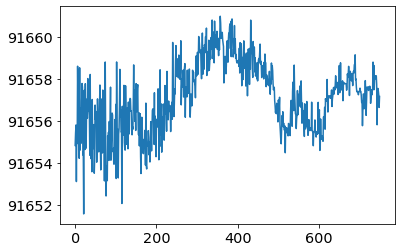

In [ ]:
print('Optimal terminal cash gained is: ',np.mean(total_cash_list[-250:]))
df_total_cash = pd.DataFrame(total_cash_list)
cash_file_name = "terminal_cash.csv"
df_total_cash.to_csv(cash_file_name)
!cp terminal_cash.csv "/content/drive/Shared drives/ProjectML/Project/Results/Cash"

plt.plot(total_cash_list)
#plt.plot(total_cash.rolling(25).mean())

Comparing with TWAP

In [ ]:
trading_time_indx = tradingTime - tradingTime[0]
trading_time_indx = [ int(x) for x in tradingTime ] #[int(x) for x in len(trading_time)]
print(trading_time_indx)

935726.1268314498


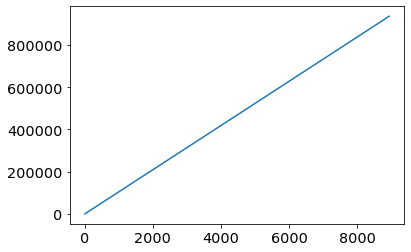

In [ ]:
Q0 = NUM_BLOCKS*BLOCK_SIZE
terminal_cash = []
cash_t = 0
for i in trading_time_indx:
    cash_t += (Q0/len(trading_time_indx))*(midprice[i+1]-0.1)
    terminal_cash.append(cash_t)

print(terminal_cash[-1])
plt.plot(trading_time_indx,terminal_cash)

Display the resulting optimal policies

In [ ]:
def print_optimal_policy(q_value):
    optimal_policy = np.zeros((NUM_BLOCKS, NUM_S, NUM_TIME_STEPS))
    for i in range(0, NUM_BLOCKS):
        for j in range(0, NUM_S):
            for k in range(0, NUM_TIME_STEPS):
                optimal_policy[i,j,k] = np.argmax(q_value[i, j, k, :])
    for k in range(0, NUM_TIME_STEPS):
      print("========= time step " + str(k) + "======") 
      print(" price: 1,2,3,4,5,6,7,8,9,10,11,12,...")
      for i in range(0, NUM_BLOCKS):
        str_="inventory " + str(i) + ":"    
        for j in range(0, NUM_S): 
            str_+=str(np.int(optimal_policy[i,j,k])) + ','
        print(str_)    

In [ ]:
#print('Sarsa Optimal Policy:')
#print_optimal_policy(q_sarsa)
#print('Q-Learning Optimal Policy:')
#print_optimal_policy(q_q_learning)

In [ ]:
def my_optimal_policy(q_value):
  optimal_policy = np.zeros((NUM_BLOCKS, NUM_S, NUM_TIME_STEPS))
  for i in range(0, NUM_BLOCKS):
    for j in range(0, NUM_S):
      for k in range(0, NUM_TIME_STEPS):
        optimal_policy[i,j,k] = np.argmax(q_value[i, j, k, :])
  for k in range(0, NUM_TIME_STEPS):
      print("Time step: ",k)
      for i in range(0, NUM_BLOCKS):   
        for j in range(0, NUM_S): 
            if np.int(optimal_policy[i,j,k]) != 0:
              print("Printing when there is an action different from zero")
              print("inventory: ",i)
              print("price index: ",j)
              print("time step: ",k)
              print(np.int(optimal_policy[i,j,k]))    
             

In [ ]:
my_optimal_policy(q_sarsa)

Time step:  0
Printing when there is an action different from zero
inventory:  49
price index:  134
time step:  0
5
Time step:  1
Printing when there is an action different from zero
inventory:  40
price index:  134
time step:  1
3
Printing when there is an action different from zero
inventory:  41
price index:  134
time step:  1
2
Printing when there is an action different from zero
inventory:  42
price index:  134
time step:  1
1
Printing when there is an action different from zero
inventory:  43
price index:  134
time step:  1
8
Printing when there is an action different from zero
inventory:  44
price index:  134
time step:  1
9
Printing when there is an action different from zero
inventory:  45
price index:  134
time step:  1
1
Printing when there is an action different from zero
inventory:  46
price index:  134
time step:  1
9
Printing when there is an action different from zero
inventory:  47
price index:  134
time step:  1
9
Printing when there is an action different from zero
i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Time step:  3941
Time step:  3942
Time step:  3943
Time step:  3944
Time step:  3945
Time step:  3946
Time step:  3947
Time step:  3948
Time step:  3949
Time step:  3950
Time step:  3951
Time step:  3952
Time step:  3953
Time step:  3954
Time step:  3955
Time step:  3956
Time step:  3957
Time step:  3958
Time step:  3959
Time step:  3960
Time step:  3961
Time step:  3962
Time step:  3963
Time step:  3964
Time step:  3965
Time step:  3966
Time step:  3967
Time step:  3968
Time step:  3969
Time step:  3970
Time step:  3971
Time step:  3972
Time step:  3973
Time step:  3974
Time step:  3975
Time step:  3976
Time step:  3977
Time step:  3978
Time step:  3979
Time step:  3980
Time step:  3981
Time step:  3982
Time step:  3983
Time step:  3984
Time step:  3985
Time step:  3986
Time step:  3987
Time step:  3988
Time step:  3989
Time step:  3990
Time step:  3991
Time step:  3992
Time step:  3993
Time step:  3994
Time